In [40]:
import os
import numpy as np
import seaborn as sns
import streamlit as st
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [41]:
train_data_dir = 'Covid19-dataset/train'
test_data_dir = 'Covid19-dataset/test'

img_width, img_height = 224, 224
batch_size = 32

In [42]:
# Prepare the data generators for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [43]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


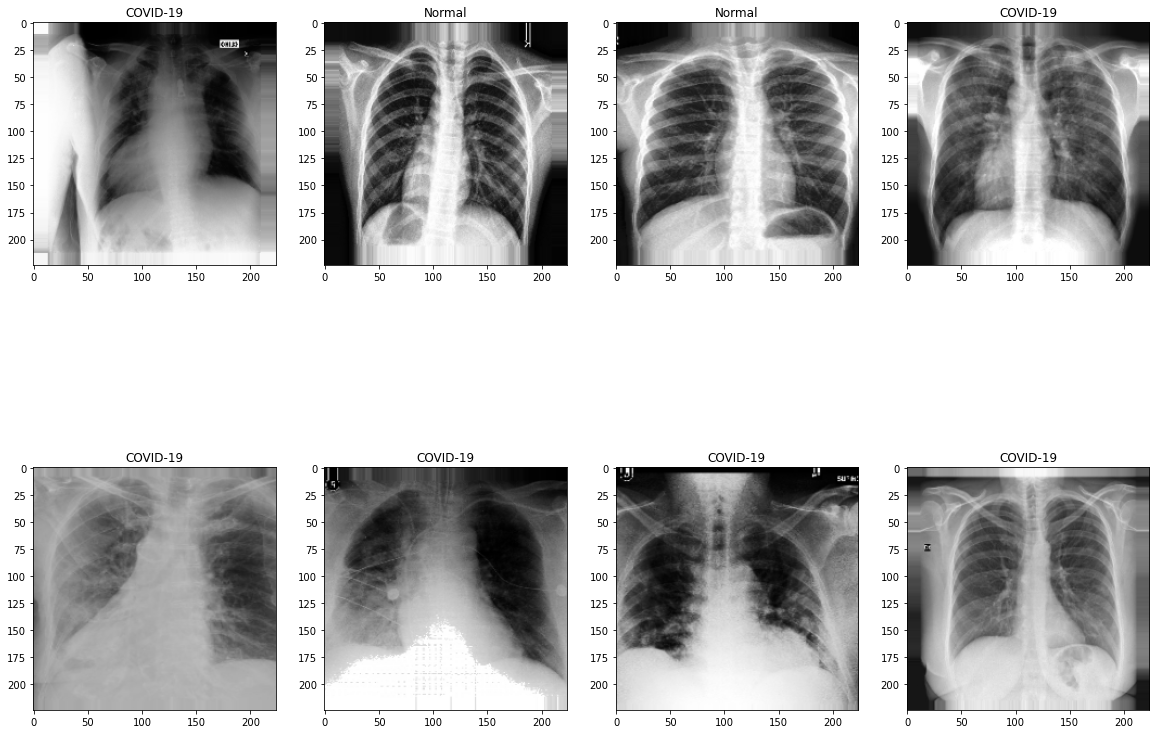

In [44]:
def display_image(generator, no_of_images):
    img_feature = generator[0][0][:no_of_images]
    img_label = generator[0][1][:no_of_images]

    plt.figure(figsize=(20, 15))
    for i in range(no_of_images):
        plt.subplot(math.ceil(no_of_images/4), 4, i+1)
        plt.imshow(img_feature[i])
        
        label_index = np.argmax(img_label[i])
        if label_index == 0:
            plt.title("COVID-19")
        elif label_index == 1:
            plt.title("Normal")
        elif label_index == 2:
            plt.title("Viral Infection")
    plt.show()

display_image(train_generator, 8)

In [48]:
# Build the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 classes: covid, normal, viral infection

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.n // batch_size
)

Epoch 1/15
7/7 [==============================] - 15s 2s/step - loss: 2.2960 - accuracy: 0.3699 - val_loss: 1.0819 - val_accuracy: 0.5469
Epoch 2/15
7/7 [==============================] - 14s 2s/step - loss: 1.0079 - accuracy: 0.6164 - val_loss: 0.7995 - val_accuracy: 0.7969
Epoch 3/15
7/7 [==============================] - 14s 2s/step - loss: 0.7000 - accuracy: 0.7489 - val_loss: 0.6257 - val_accuracy: 0.7188
Epoch 4/15
7/7 [==============================] - 13s 2s/step - loss: 0.6125 - accuracy: 0.7489 - val_loss: 0.6085 - val_accuracy: 0.6875
Epoch 5/15
7/7 [==============================] - 13s 2s/step - loss: 0.4933 - accuracy: 0.8219 - val_loss: 0.2931 - val_accuracy: 0.9531
Epoch 6/15
7/7 [==============================] - 14s 2s/step - loss: 0.4739 - accuracy: 0.7946 - val_loss: 0.3758 - val_accuracy: 0.8750
Epoch 7/15
7/7 [==============================] - 14s 2s/step - loss: 0.4536 - accuracy: 0.8082 - val_loss: 0.2285 - val_accuracy: 0.8906
Epoch 8/15
7/7 [==================

In [49]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

3/3 [==============================] - 1s 357ms/step - loss: 0.2443 - accuracy: 0.9545
Test loss: 0.24431268870830536
Test accuracy: 0.9545454382896423


3/3 [==============================] - 1s 160ms/step


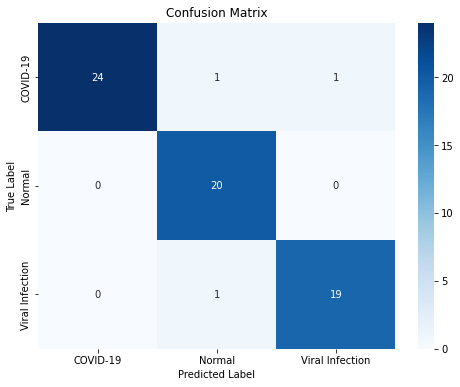

Classification Report:
                 precision    recall  f1-score   support

       COVID-19       1.00      0.92      0.96        26
         Normal       0.91      1.00      0.95        20
Viral Infection       0.95      0.95      0.95        20

       accuracy                           0.95        66
      macro avg       0.95      0.96      0.95        66
   weighted avg       0.96      0.95      0.95        66



In [50]:
import numpy as np
import matplotlib.pyplot as plt


# Load the test data
X_test = []
y_true = []

for i in range(len(test_generator)):
    batch = test_generator[i]
    X_test.extend(batch[0])
    y_true.extend(batch[1])

X_test = np.array(X_test)
y_true = np.argmax(np.array(y_true), axis=1)

# Get the predicted labels
y_pred = np.argmax(model.predict(X_test), axis=1)

# Build the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ['COVID-19', 'Normal', 'Viral Infection']

# Create a figure for the confusion matrix
plt.figure(figsize=(8, 6))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set plot labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

# Calculate evaluation metrics
report = classification_report(y_true, y_pred, target_names=class_labels)

# Print the classification report
print('Classification Report:')
print(report)


In [51]:
from tensorflow.keras.models import load_model

# Save the model to an .h5 file
model.save('model_upd.h5')